In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [2]:
custom_image_path = r"D:\Semester 2\C++ Case study\Python model\Model\Train"

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 56 * 56, 64)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(64, 2)  # 2 output classes

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
dataset = ImageFolder(root=custom_image_path, transform=transform)

In [6]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [7]:
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [8]:
model = SimpleCNN()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=64, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 1/10, Train Loss: 1.3254, Val Loss: 0.3870, Val Accuracy: 0.8095
Epoch 2/10, Train Loss: 0.3251, Val Loss: 0.2955, Val Accuracy: 0.8810
Epoch 3/10, Train Loss: 0.2584, Val Loss: 0.2511, Val Accuracy: 0.8810
Epoch 4/10, Train Loss: 0.2056, Val Loss: 0.2178, Val Accuracy: 0.8810
Epoch 5/10, Train Loss: 0.1507, Val Loss: 0.2462, Val Accuracy: 0.8333
Epoch 6/10, Train Loss: 0.0726, Val Loss: 0.4092, Val Accuracy: 0.7381
Epoch 7/10, Train Loss: 0.0394, Val Loss: 0.1978, Val Accuracy: 0.8333
Epoch 8/10, Train Loss: 0.0146, Val Loss: 0.3003, Val Accuracy: 0.8571
Epoch 9/10, Train Loss: 0.0133, Val Loss: 0.4710, Val Accuracy: 0.8095
Epoch 10/10, Train Loss: 0.1091, Val Loss: 0.4150, Val Accuracy: 0.8571


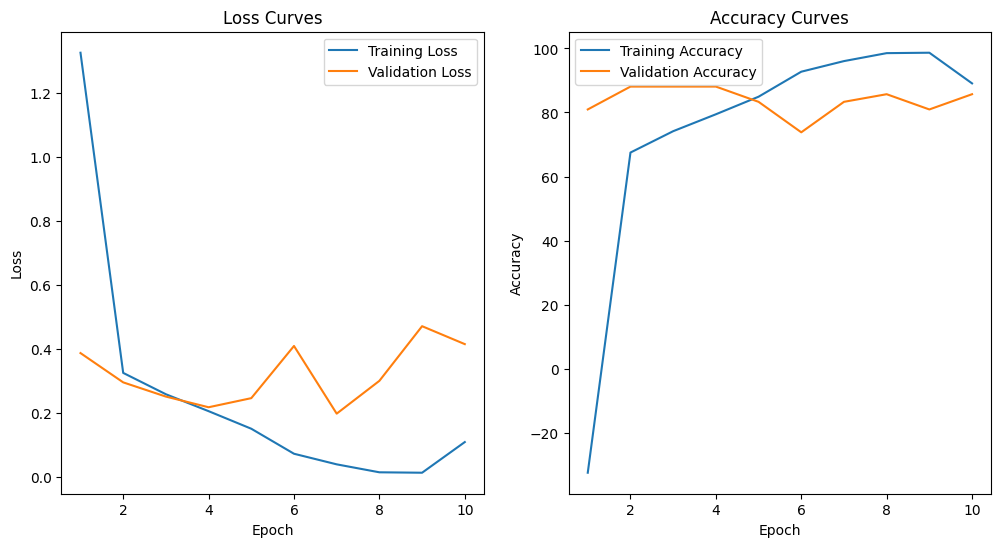

In [10]:
import matplotlib.pyplot as plt

# Initialize lists to store the training and validation losses and accuracies
train_losses = []
val_losses = []
train_acc = []
val_acc = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

    model.eval()
    val_loss = 0.0
    val_corrects = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)

    train_loss = train_loss / len(train_loader.dataset)
    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = val_corrects.double() / len(val_loader.dataset)

    # Append the training and validation losses and accuracies to the lists
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_acc.append(100 * (1 - train_loss))
    val_acc.append(100 * val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

# Plot the training and validation losses and accuracies
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(range(1, num_epochs+1), train_acc, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [11]:
torch.save(model.state_dict(), 'custom_cnn_model.pth')

In [12]:
from PIL import Image

image = Image.open(r"D:\Semester 2\C++ Case study\Python model\Model\Test\Glaucoma\Glaucoma_040.png")
image_tensor = transform(image).unsqueeze(0).to(device)

In [13]:
model.eval()

# Make the prediction
with torch.no_grad():
    outputs = model(image_tensor)
    _, predicted = torch.max(outputs, 1)

# Map the predicted index to the class label
class_labels = ['cataract','glaucoma']
prediction = class_labels[predicted.item()]

print(f"The image is classified as: {prediction}")

The image is classified as: glaucoma
